**THIS IS A COPY FROM NIELS ROGGE'S [NOTEBOOK FOR DOC CLASSIFICATION](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/RVL-CDIP/Fine_tune_Donut_on_toy_RVL_CDIP_(document_image_classification).ipynb) USED ONLY FOR BENCHMARKING. WE RUN IT AGAIN TO BE ABLE TO COMPARE THE ACCURACY AND INFERENCE TIME WITH OUR OWN MODEL.**






## Set-up environment

First, let's install the relevant libraries: 🤗 Transformers & Datasets, and Sentencepiece (the latter is used for tokenization).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


## Load dataset

Next, let's load a dataset from the hub. I've prepared a toy dataset which is a small subset of [RVL-CDIP](https://paperswithcode.com/dataset/rvl-cdip), consisting of (image, text) pairs. The text is what the model should learn to generate given the visual input.

Here, it's important to understand how targets should be prepared for Donut: you need to create a string called "ground_truth" (or "ground_truths", in case there are multiple possible ground truth target sequences, see DocVQA). This is a string format of a dictionary (JSON dumped), containing either a `gt_parse` or `gt_parses` key.

For document image classification, the `gt_parse` follows the format of `{"class" : {class_name}}`, for example, `{"class" : "scientific_report"}` or `{"class" : "presentation"}`.

The notebook for creating a 🤗 Dataset (custom data) for Donut can be found in my Github repo [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/RVL-CDIP/Preparing_an_image_classification_dataset_for_Donut.ipynb).

Let's load the dataset first:



In [3]:
from datasets import load_dataset

dataset = load_dataset("nielsr/rvl_cdip_10_examples_per_class_donut")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/160 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/160 [00:00<?, ? examples/s]

In [4]:
id2label = {id: label for id, label in enumerate(dataset['train'].features['label'].names)}
print(id2label)

{0: 'letter', 1: 'form', 2: 'email', 3: 'handwritten', 4: 'advertisement', 5: 'scientific report', 6: 'scientific publication', 7: 'specification', 8: 'file folder', 9: 'news article', 10: 'budget', 11: 'invoice', 12: 'presentation', 13: 'questionnaire', 14: 'resume', 15: 'memo'}


Let's check out an example:

In [5]:
example = dataset['train'][0]
example

{'image': <PIL.Image.Image image mode=L size=762x1000>,
 'label': 0,
 'ground_truth': '{"gt_parse": {"class" : "letter"}}'}

As can be seen, we prepared the "ground_truth" key, which is a string-formatted dictionary containing a single `gt_parse` key.

In [6]:
example = dataset["train"][0]
example["ground_truth"]

'{"gt_parse": {"class" : "letter"}}'

One can use Python's `ast.literal_eval` function to turn the string into a Python dictionary. This helps verifying we have created the gt_parse string in the correct way:

In [7]:
from ast import literal_eval

literal_eval(example["ground_truth"])['gt_parse']

{'class': 'letter'}

## Load model and processor

Next, we'll load the model itself (Donut is an instance of the [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder) class), as well as its processor (`DonutProcessor`), which can be used to prepare data for the model.

We'll update some things; namely the max sequence length of the decoder, as well as the size of the images. Note that this impacts the amount of memory used when fine-tuning the model.

Note that the exact hyperparameters can be found here: https://github.com/clovaai/donut/blob/master/config/train_rvlcdip.yaml.

In [8]:
from transformers import VisionEncoderDecoderConfig

max_length = 8
# image_size = [2560, 1920]
# let's use a smaller image size (height, width) because otherwise OOM
# the higher the resolution, the better the results will be
# so if you have a big GPU, feel free to increase
image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("nielsr/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

In [9]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained("nielsr/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-base", config=config)

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

In [10]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:193: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


## Prepare dataset

The first thing we'll do is add the class names as added tokens to the vocabulary of the decoder of Donut, and the corresponding tokenizer.

This will result in a slight increase in performance, as otherwise a class might be split up into multiple subword tokens (e.g. the class "advertisement" might be split up into "adv", "ertisement"). It is beneficial to let the model just learn a single embedding vector for the token "advertisement".

In [11]:
len(processor.tokenizer)

57525

In [12]:
from typing import List

def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

In [13]:
additional_tokens = ["<advertisement/>", "<budget/>", "<email/>", "<file_folder/>", "<form/>", "<handwritten/>", "<invoice/>",
  "<letter/>", "<memo/>", "<news_article/>", "<presentation/>", "<questionnaire/>", "<resume/>",
  "<scientific_publication/>", "<scientific_report/>", "<specification/>"]

add_tokens(additional_tokens)

In [14]:
processor.tokenizer.convert_tokens_to_ids(["<file_folder/>"])

[57528]

In [15]:
len(processor.tokenizer)

57541

Next, we create a regular PyTorch Dataset. The class below returns `(pixel_values, labels)` pairs for each item of the dataset.

It's all we need for training the model!

In [16]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in additional_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # pixel values (we remove the batch dimension)
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # labels, which are the input ids of the target sequence
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)

        encoding = dict(pixel_values=pixel_values,
                        labels=labels)

        return encoding

Let's create the dataset:

In [17]:
train_dataset = DonutDataset("nielsr/rvl_cdip_10_examples_per_class_donut", max_length=max_length,
                             split="train", task_start_token="<s_rvlcdip>", prompt_end_token="<s_rvlcdip>",
                             sort_json_key=False, # rvlcdip dataset is preprocessed, so no need for this
                             )

Let's check the first item of this dataset:

In [18]:
train_dataset[0]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': tensor([57541, 57532, 57542,     2,  -100,  -100,  -100

## Create PyTorch DataLoader

Now that we've created a PyTorch dataset, we can create a corresponding DataLoader:



In [19]:
from torch.utils.data import DataLoader

# I'm using a small batch size to make sure it fits in the memory Colab provides
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

Let's check out the first batch:

In [20]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['pixel_values', 'labels'])


Let's check the labels:

In [21]:
for id in batch['labels'][0].tolist():
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_class>
<news_article/>
</s_class>
</s>
-100
-100
-100
-100


Let's visualize the pixel values by denormalizing:

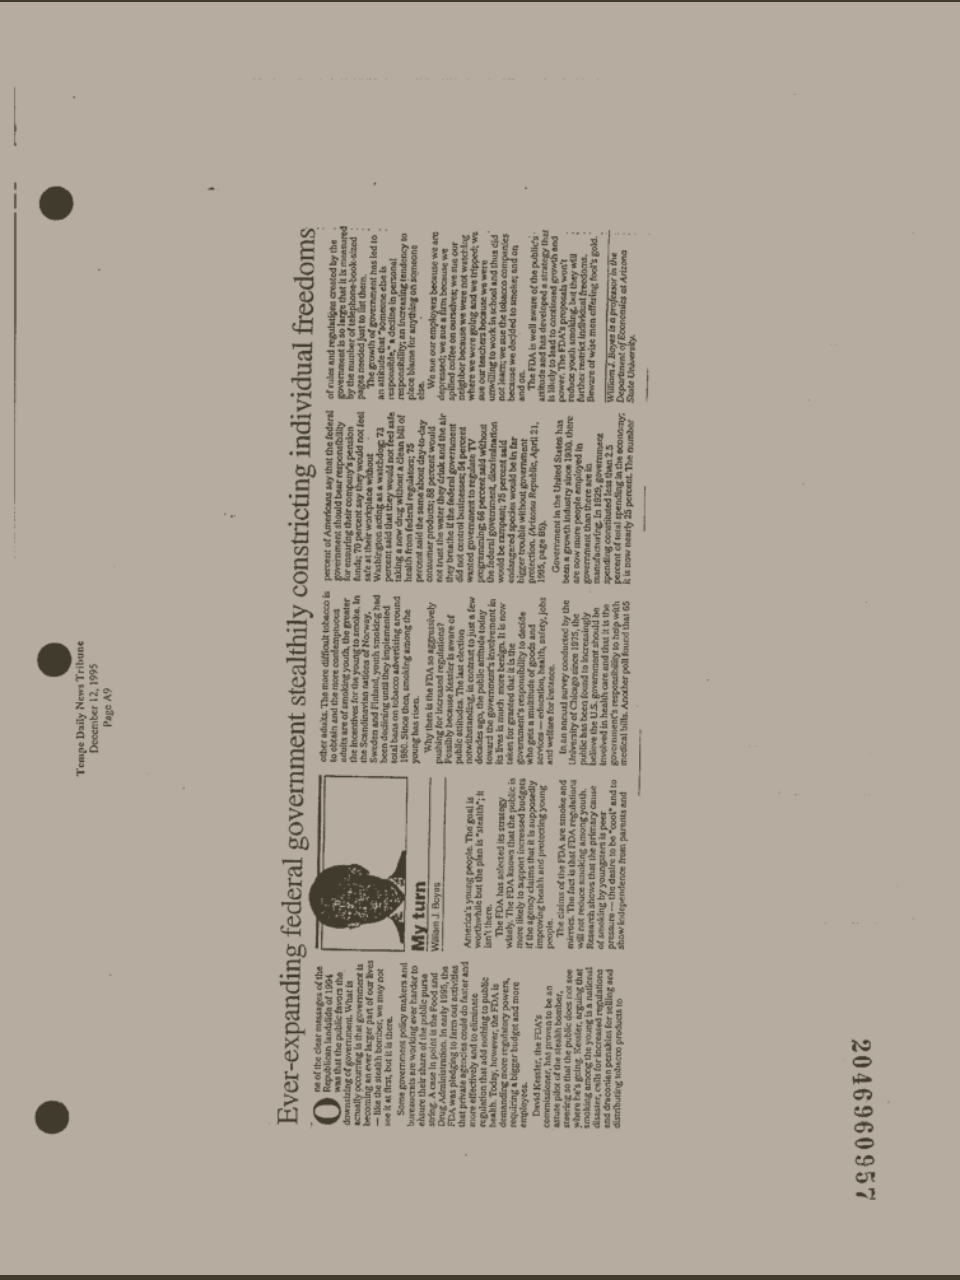

In [22]:

from PIL import Image
import numpy as np

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# unnormalize
reconstructed_image = (batch['pixel_values'][0] * torch.tensor(std)[:, None, None]) + torch.tensor(mean)[:, None, None]
# unrescale
reconstructed_image = reconstructed_image * 255
# convert to numpy of shape HWC
reconstructed_image = torch.moveaxis(reconstructed_image, 0, -1)
image = Image.fromarray(reconstructed_image.numpy().astype(np.uint8))
image

This indeed looks like an email. So data preparation seems ok!

## Train model

Ok there's one additional thing before we can start training the model: during training, the model can create the `decoder_input_ids` (the decoder inputs) automatically based on the `labels` (by simply shifting them one position to the right, prepending the `decoder_start_token_id` and replacing labels which are -100 by the `pad_token_id`). Therefore, we need to set those variables, to make sure the `decoder_input_ids` are created automatically.

This ensures we only need to prepare labels for the model. Theoretically you can also create the `decoder_input_ids` yourself and not set the 2 variables below. This is what the original authors of Donut did.

In [23]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_rvlcdip>'])[0]

In [24]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_rvlcdip>


Let's train!

In [ ]:
import torch
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)

for epoch in range(20):
    print("Epoch:", epoch+1)
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = model(pixel_values=pixel_values,
                        labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print("Loss:", loss.item())

    if epoch + 1 in {5, 10, 15, 20}:
        checkpoint_path = f"model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved at {checkpoint_path}")

Epoch: 1


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 38.30393600463867
Loss: 2.3016717433929443
Epoch: 2


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 2.314802408218384
Loss: 1.4176145792007446
Epoch: 3


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.8299262523651123
Loss: 0.9206946492195129
Epoch: 4


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 1.2647005319595337
Loss: 0.7464114427566528
Epoch: 5


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.17448638379573822
Loss: 0.8420423269271851
Model saved at model_epoch_5.pth
Epoch: 6


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.6477702260017395
Loss: 0.10161066055297852
Epoch: 7


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.4222767949104309
Loss: 0.7823960781097412
Epoch: 8


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.753022313117981
Loss: 0.8979454040527344
Epoch: 9


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.2755392789840698
Loss: 0.3732031285762787
Epoch: 10


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.8105296492576599
Loss: 0.257393479347229
Model saved at model_epoch_10.pth
Epoch: 11


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.2748190462589264
Loss: 0.11614831537008286
Epoch: 12


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.11624950915575027
Loss: 0.16643376648426056
Epoch: 13


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.09763053059577942
Loss: 0.39625319838523865
Epoch: 14


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.3404896855354309
Loss: 0.2847987413406372
Epoch: 15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.003891164902597666
Loss: 0.04117591679096222
Model saved at model_epoch_15.pth
Epoch: 16


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.392275869846344
Loss: 0.09805309027433395
Epoch: 17


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.0695568099617958
Loss: 0.12215247005224228
Epoch: 18


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.20447008311748505
Loss: 0.07768785208463669
Epoch: 19


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.03219286724925041
Loss: 0.06739853322505951
Epoch: 20


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.004846472293138504


## Evaluate

Finally, we compute the accuracy on the test set.

Note that this will be far from perfect as we were just training on a toy dataset. The entire dataset consists of 400,000 images.

We'll verify whether the model is better than random (which means 1/number of classes = 1/16 = 0.0625) accuracy.

We'll use the token2json method of the processor to turn the generated sequences into JSON.

In [26]:
import re
import time
import numpy as np

model.eval()

model.load_state_dict(torch.load('/content/model_epoch_5.pth'))

dataset = load_dataset("nielsr/rvl_cdip_10_examples_per_class_donut", split="test")
inference_time = []

output_list = []
accs = []
for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)

    start_time = time.time()
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )
    end_time = time.time()

    inference_time.append(end_time - start_time)

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    gt = ground_truth["gt_parse"]
    score = float(seq["class"] == gt["class"])

    accs.append(score)

    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

print(f'Accuracy: {np.round(np.mean(accs)*100,2)}%')
print(f"Average Inference time: {np.mean(inference_time):.6f} seconds")

  0%|          | 0/160 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


{'accuracies': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'mean_accuracy': 0.23125} length : 160
Accuracy: 23.12%
Average Inference time: 0.311698 seconds


In [27]:
model.eval()

model.load_state_dict(torch.load('/content/model_epoch_10.pth'))

dataset = load_dataset("nielsr/rvl_cdip_10_examples_per_class_donut", split="test")
inference_time = []

output_list = []
accs = []
for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)

    start_time = time.time()
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )
    end_time = time.time()

    inference_time.append(end_time - start_time)

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    gt = ground_truth["gt_parse"]
    score = float(seq["class"] == gt["class"])

    accs.append(score)

    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

print(f'Accuracy: {np.round(np.mean(accs)*100,2)}%')
print(f"Average Inference time: {np.mean(inference_time):.6f} seconds")

  0%|          | 0/160 [00:00<?, ?it/s]

{'accuracies': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 'mean_accuracy': 0.4125} length : 160
Accuracy: 41.25%
Average Inference time: 0.300321 seconds


In [28]:
model.eval()

model.load_state_dict(torch.load('/content/model_epoch_15.pth'))

dataset = load_dataset("nielsr/rvl_cdip_10_examples_per_class_donut", split="test")
inference_time = []

output_list = []
accs = []
for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)

    start_time = time.time()
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )
    end_time = time.time()

    inference_time.append(end_time - start_time)

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    gt = ground_truth["gt_parse"]
    score = float(seq["class"] == gt["class"])

    accs.append(score)

    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

print(f'Accuracy: {np.round(np.mean(accs)*100,2)}%')
print(f"Average Inference time: {np.mean(inference_time):.6f} seconds")

  0%|          | 0/160 [00:00<?, ?it/s]

{'accuracies': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0], 'mean_accuracy': 0.48125} length : 160
Accuracy: 48.12%
Average Inference time: 0.304114 seconds


In [29]:
model.eval()

model.load_state_dict(torch.load('/content/model_epoch_20.pth'))

dataset = load_dataset("nielsr/rvl_cdip_10_examples_per_class_donut", split="test")
inference_time = []

output_list = []
accs = []
for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)

    start_time = time.time()
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )
    end_time = time.time()

    inference_time.append(end_time - start_time)

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    gt = ground_truth["gt_parse"]
    score = float(seq["class"] == gt["class"])

    accs.append(score)

    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

print(f'Accuracy: {np.round(np.mean(accs)*100,2)}%')
print(f"Average Inference time: {np.mean(inference_time):.6f} seconds")

  0%|          | 0/160 [00:00<?, ?it/s]

{'accuracies': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0], 'mean_accuracy': 0.5125} length : 160
Accuracy: 51.25%
Average Inference time: 0.298890 seconds


That looks a lot better than random accuracy, suggesting that our model seems to learn well!